In [239]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [150]:
data = np.load('data.npz')

X1_obs = data['X1_obs']
X1_h1 = data['X1_h1']
X1_h2 = data['X1_h2']
X1_act = data['X1_act']
X2_obs = data['X2_obs']
X2_h1 = data['X2_h1']
X2_h2 = data['X2_h2']
X2_act = data['X2_act']
X3_obs = data['X3_obs']
X3_h1 = data['X3_h1']
X3_h2 = data['X3_h2']
X3_act = data['X3_act']
y1 = data['y1']
y2 = data['y2']
y3 = data['y3']

In [215]:
def train_and_test(X, y):
    # only episodes where the other agent covers just one landmark 
    idx = np.where(np.sum(y, axis=-1) == 1)[0]
    X = X[idx]
    y = y[idx]

    # duplicate the last step landmark data over all episode timesteps
    y = y[:, np.newaxis, :]
    y = y.repeat(X.shape[1], axis=1)
    y = np.argmax(y, axis=-1) # convert one-hot vector into indices

    # split into training and test episodes (NB! this is done at episode level!)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

    # use only middle 5 steps for testing
    X_test = X_test[:, 10:15]
    y_test = y_test[:, 10:15]
    
    # get rid of the episode dimension
    X_train = X_train.reshape((-1, X.shape[2]))
    X_test = X_test.reshape((-1, X.shape[2]))
    y_train = y_train.reshape((-1,))
    y_test = y_test.reshape((-1,))

    # normalize input features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train linear classifier
    #clf = SVC(kernel='linear', C=1, cache_size=1000)
    #clf = LinearSVC(C=1)
    #clf = SGDClassifier()
    #clf = LinearDiscriminantAnalysis()
    clf = MLPClassifier(hidden_layer_sizes=tuple(), solver='adam')
    clf.fit(X_train, y_train)

    # calculate training and test accuracy
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [235]:
acc = np.empty((3, 3, 4, 2))
for i in range(3):
    for j in range(3):
        acc[i, j, 0] = train_and_test(data['X%d_obs' % (i + 1)], data['y%d' % (j + 1)])
        acc[i, j, 1] = train_and_test(data['X%d_h1' % (i + 1)], data['y%d' % (j + 1)])
        acc[i, j, 2] = train_and_test(data['X%d_h2' % (i + 1)], data['y%d' % (j + 1)])
        acc[i, j, 3] = train_and_test(data['X%d_act' % (i + 1)], data['y%d' % (j + 1)])

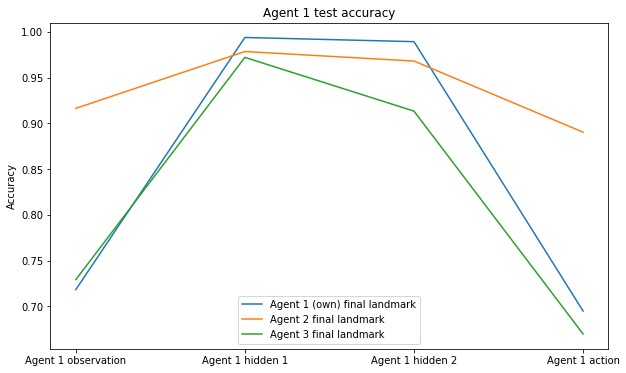

In [262]:
plt.figure(figsize=(10, 6))
plt.plot(acc[0, :, :, 1].T)
plt.ylabel('Accuracy')
#plt.xlabel('Features')
plt.title('Agent 1 test accuracy')
plt.xticks(range(4), ['Agent 1 observation', 'Agent 1 hidden 1', 'Agent 1 hidden 2', 'Agent 1 action'])
plt.legend(['Agent 1 (own) final landmark', 'Agent 2 final landmark', 'Agent 3 final landmark'], loc='lower center')

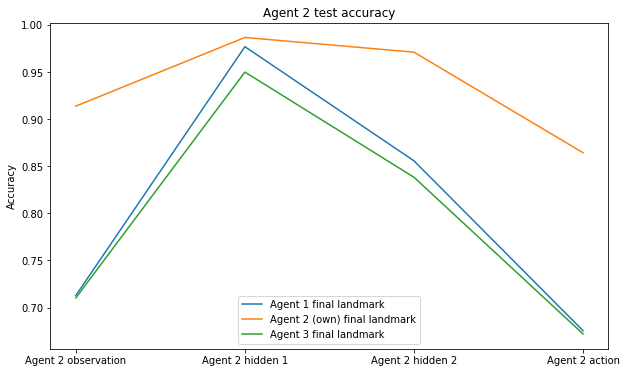

In [263]:
plt.figure(figsize=(10, 6))
plt.plot(acc[1, :, :, 1].T)
plt.ylabel('Accuracy')
#plt.xlabel('Features')
plt.title('Agent 2 test accuracy')
plt.xticks(range(4), ['Agent 2 observation', 'Agent 2 hidden 1', 'Agent 2 hidden 2', 'Agent 2 action'])
plt.legend(['Agent 1 final landmark', 'Agent 2 (own) final landmark', 'Agent 3 final landmark'], loc='lower center')

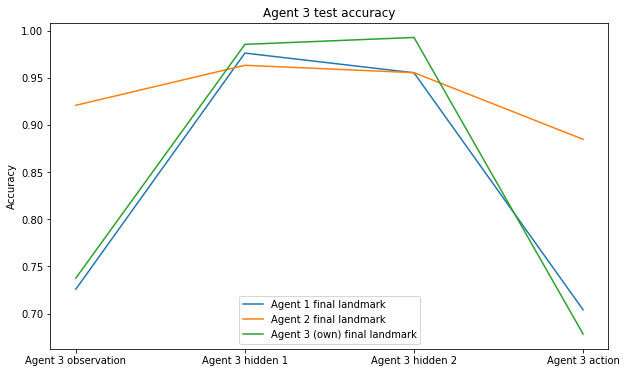

In [264]:
plt.figure(figsize=(10, 6))
plt.plot(acc[2, :, :, 1].T)
plt.ylabel('Accuracy')
#plt.xlabel('Features')
plt.title('Agent 3 test accuracy')
plt.xticks(range(4), ['Agent 3 observation', 'Agent 3 hidden 1', 'Agent 3 hidden 2', 'Agent 3 action'])
plt.legend(['Agent 1 final landmark', 'Agent 2 final landmark', 'Agent 3 (own) final landmark'], loc='lower center')

## Agent 1

### Predict Agent1 (itself)

In [220]:
ag1_obs_acc = train_and_test(X1_obs, y1)
ag1_obs_acc

(0.7248967551622418, 0.6880733944954128)

In [223]:
ag1_h1_acc = train_and_test(X1_h1, y1)
ag1_h1_acc

(0.9801376597836775, 0.9919724770642202)

In [224]:
ag1_h2_acc = train_and_test(X1_h2, y1)
ag1_h2_acc

(0.9771878072763028, 0.993348623853211)

In [225]:
ag1_act_acc = train_and_test(X1_act, y1)
ag1_act_acc

(0.6819075712881023, 0.6811926605504587)

### Predict Agent2

In [226]:
ag2_obs_acc = train_and_test(X1_obs, y2)
ag2_obs_acc

(0.9217238627294493, 0.8988847583643123)

In [227]:
ag2_h1_acc = train_and_test(X1_h1, y2)
ag2_h1_acc

(0.9733758978451715, 0.9821561338289962)

In [228]:
ag2_h2_acc = train_and_test(X1_h2, y2)
ag2_h2_acc

(0.9510933758978452, 0.9639405204460967)

In [229]:
ag2_act_acc = train_and_test(X1_act, y2)
ag2_act_acc

(0.8922585794094174, 0.8717472118959108)

### Predict Agent3

In [230]:
ag3_obs_acc = train_and_test(X1_obs, y3)
ag3_obs_acc

(0.7189293954776188, 0.6935483870967742)

In [231]:
ag3_h1_acc = train_and_test(X1_h1, y3)
ag3_h1_acc

(0.956677434240886, 0.9726881720430107)

In [232]:
ag3_h2_acc = train_and_test(X1_h2, y3)
ag3_h2_acc

(0.9096262113520996, 0.8995698924731182)

In [233]:
ag3_act_acc = train_and_test(X1_act, y3)
ag3_act_acc

(0.6760498384863867, 0.6989247311827957)

## Agent 2

### Predict Agent1

In [187]:
train_and_test(X2_obs, y1)

(0.7126253687315635, 0.7286697247706422)

In [188]:
train_and_test(X2_h1, y1)

(0.9396853490658801, 0.9722477064220183)

In [189]:
train_and_test(X2_h2, y1)

(0.8401376597836775, 0.8483944954128441)

In [190]:
train_and_test(X2_act, y1)

(0.6887905604719764, 0.6651376146788991)

### Predict Agent2 (itself)

In [191]:
train_and_test(X2_obs, y2)

(0.9262569832402234, 0.9096654275092937)

In [192]:
train_and_test(X2_h1, y2)

(0.9780047885075818, 0.9836431226765799)

In [193]:
train_and_test(X2_h2, y2)

(0.9793455706304869, 0.9676579925650558)

In [194]:
train_and_test(X2_act, y2)

(0.8834796488427773, 0.8921933085501859)

### Predict Agent3

In [195]:
train_and_test(X2_obs, y3)

(0.7190032302722658, 0.7268817204301076)

In [196]:
train_and_test(X2_h1, y3)

(0.9244300876788186, 0.9466666666666667)

In [197]:
train_and_test(X2_h2, y3)

(0.8256022150438395, 0.8458064516129032)

In [198]:
train_and_test(X2_act, y3)

(0.6843562528841717, 0.6795698924731183)

## Agent 3

### Predict Agent1

In [199]:
train_and_test(X3_obs, y1)

(0.7060766961651918, 0.7282110091743119)

In [200]:
train_and_test(X3_h1, y1)

(0.9667256637168141, 0.9768348623853211)

In [201]:
train_and_test(X3_h2, y1)

(0.9393510324483776, 0.9493119266055046)

In [202]:
train_and_test(X3_act, y1)

(0.6892822025565388, 0.6639908256880734)

### Predict Agent2

In [203]:
train_and_test(X3_obs, y2)

(0.9162011173184358, 0.9256505576208178)

In [204]:
train_and_test(X3_h1, y2)

(0.9650758180367119, 0.9661710037174721)

In [205]:
train_and_test(X3_h2, y2)

(0.9307262569832402, 0.9513011152416357)

In [206]:
train_and_test(X3_act, y2)

(0.8842777334397446, 0.8903345724907064)

### Predict Agent3 (itself)

In [207]:
train_and_test(X3_obs, y3)

(0.7259437009690817, 0.7290322580645161)

In [208]:
train_and_test(X3_h1, y3)

(0.9764467005076142, 0.9881720430107527)

In [209]:
train_and_test(X3_h2, y3)

(0.9726442085832949, 0.9851612903225806)

In [210]:
train_and_test(X3_act, y3)

(0.6848177203507153, 0.678494623655914)